# Introduction

# 1. Setup

## 1.1. Using Colab GPU for Training


GPU 사용 가능 여부 확인

In [1]:
import torch

if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2. Installing the Hugging Face Library


현재 Hugging Face 라이브러리는 BERT 작업을 위한 가장 널리 사용되는 인터페이스입니다. 사전 훈련된 다양한 transformer 모델을 지원하는 것 외에도 라이브러리에는 특정 작업에 적합한 이러한 모델의 사전 구축된 수정 사항도 포함되어 있습니다. 예를 들어, 본 과제에서는 `BertForSequenceClassification`을 사용합니다.

라이브러리에는 토큰 분류, 질문 답변, 다음 문장 예측 등을 위한 작업별 클래스도 포함되어 있습니다. 이러한 사전 구축된 클래스를 사용하면 목적에 맞게 BERT를 수정하는 프로세스가 단순화됩니다.

In [2]:
!pip install transformers

# 2. Loading CoLA Dataset


단일 문장 분류에는 [CoLA(The Corpus of Linguistic Acceptability)](https://nyu-mll.github.io/CoLA/) 데이터세트를 사용하겠습니다. 문법적으로 정확하거나 틀린 것으로 표시된 문장 데이터셋입니다. 2018년 5월에 처음 공개되었으며 BERT와 같은 모델이 평가되는 "GLUE 벤치마크"에 포함된 테스트 중 하나입니다.

## 2.1. Download & Extract

`wget` 패키지로 데이터를 다운로드합니다.

In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=ae08f75991ae5e69c981433d5115bfc0da00cdfee0291a6f411ce359c4ba1573
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:
import wget
import os

print('Downloading dataset...')

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [5]:
# Unzip
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


## 2.2. Parse

In [6]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of training sentences: {:,}\n'.format(df.shape[0]))

df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
4099,ks08,0,*,Why don't you leaving me concentrate on my work?
4967,ks08,0,*,Who is that he has met extremely unlikely?
8133,ad03,1,NaN,Lee's youngest and Dawn's oldest son ran away.
2333,l-93,0,*,The jeweller copied the ring with the name.
503,bc01,0,*,John would be hated to win.
2082,rhl07,1,NaN,"I threw the ball to Julian, but it fell short ..."
3545,ks08,1,NaN,They read the scientific book.
6608,g_81,1,NaN,"Smith loaned, and his widow later donated, a v..."
6823,m_02,1,NaN,Martha chewed the bread.
4754,ks08,1,NaN,Who do you think Hobbs imagined Mary said Tom ...


`sentence` 와 `label`만 남기겠습니다.

In [7]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
7578,I like Mary and she does too.,0
8459,Anson believed Jenny to have hurt himself.,0
3415,The book valued $200.,0
6760,The person who in came at that moment was Aunt...,0
57,The building is tall and tall.,0


In [8]:
sentences = df.sentence.values
labels = df.label.values

# 3. Tokenization & Input Formatting

이 섹션에서는 데이터 세트를 BERT가 학습할 수 있는 형식으로 변환합니다.

## 3.1. BERT Tokenizer

텍스트를 BERT에 공급하려면 텍스트를 토큰으로 분할한 다음 이러한 토큰을 토크나이저 어휘의 인덱스에 매핑해야 합니다.

토큰화는 BERT에 포함된 토크나이저에 의해 수행되어야 합니다.

In [9]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


실제로 모든 문장을 변환할 때 `tokenize`와 `convert_tokens_to_ids`를 별도로 호출하는 대신 `tokenize.encode` 함수를 사용하여 두 단계를 모두 처리합니다.

하지만 그렇게 하기 전에 BERT의 형식 요구 사항 중 일부에 대해 살펴보겠습니다다.

## 3.2. Required Formatting

위의 코드에는 여기서 살펴볼 몇 가지 필수 형식 지정 단계가 생략되었습니다.


우리는 다음을 수행해야 합니다.
1. 각 문장의 시작과 끝 부분에 특수 토큰을 추가.
2. 모든 문장을 하나의 일정한 길이로 채우고 자릅니다.
3. "attention mask"를 사용하여 실제 토큰과 패딩 토큰을 명시적으로 구별합니다.

### Special Tokens


**`[SEP]`**

모든 문장 끝에 특수 `[SEP]` 토큰을 추가해야 합니다.

이 토큰은 BERT에 두 개의 별도 문장이 제공됨을 알립니다.

**`[CLS]`**

분류 작업을 위해서는 모든 문장의 시작 부분에 특수 `[CLS]` 토큰을 추가해야 합니다.

이 토큰은 특별한 의미를 갖습니다. BERT는 12개의 Transformer 레이어로 구성됩니다. 각 transformer는 토큰 임베딩 목록을 가져와 출력에 동일한 수의 임베딩을 생성합니다.

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

최종(12번째) transformer의 출력에서 *classifier는 *첫 번째 임베딩([CLS] 토큰에 해당)만 사용합니다*.

또한 BERT는 분류를 위해 이 [CLS] 토큰만 사용하도록 훈련되었기 때문에 모델이 분류 단계에 필요한 모든 것을 단일 768 값 임베딩 벡터로 인코딩하도록 되었습니다.



### Sentence Length & Attention Mask



BERT에는 두 가지 제약 조건이 있습니다.
1. 모든 문장은 고정된 단일 길이로 채워지거나 잘려야 합니다.
2. 최대 문장 길이는 512 토큰입니다.

패딩은 BERT 어휘의 인덱스 0에 있는 특수 `[PAD]` 토큰을 사용하여 수행됩니다. 아래 그림은 8개 토큰의 "MAX_LEN"에 대한 패딩을 보여줍니다.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

"attention mask"는 단순히 패딩되는 토큰과 패딩되지 않는 토큰을 나타내는 1과 0의 배열입니다.


## 3.2. Sentences to IDs

`tokenizer.encode` 함수는 여러 단계를 결합합니다:
1. 문장을 토큰으로 나눕니다.
2. 특수 `[CLS]` 및 `[SEP]` 토큰을 추가합니다.
3. 토큰을 해당 ID에 매핑합니다.


In [11]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


## 3.3. Padding & Truncating

시퀀스를 모두 채우고 잘라서 길이가 모두 'MAX_LEN'이 되도록 합니다.

First, what's the maximum sentence length in our dataset?

In [12]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  47


In [13]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0

Done.


## 3.4. Attention Masks

어텐션 마스크는 어떤 토큰이 실제 단어인지, 어떤 토큰이 패딩인지를 명확하게 보여줍니다.

BERT 어휘는 ID 0을 사용하지 않으므로 토큰 ID가 0이면 패딩이고 그렇지 않으면 실제 토큰입니다.

In [14]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

## 3.5. Training & Validation Split


train/test를 분리합니다.

In [15]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

## 3.6. Converting to PyTorch Data Types

우리 모델은 numpy.ndarrays 대신 PyTorch 텐서를 사용합니다.

In [16]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

또한 토치 DataLoader 클래스를 사용하여 데이터세트에 대한 반복자를 생성합니다. 이는 for 루프와 달리 반복자를 사용하면 전체 데이터세트를 메모리에 로드할 필요가 없기 때문에 훈련 중에 메모리를 절약하는 데 도움이 됩니다.

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# 4. Train Our Classification Model

## 4.1. BertForSequenceClassification

이 작업을 위해 먼저 사전 훈련된 BERT 모델을 수정하여 분류를 위한 출력을 제공한 다음 전체 모델이 엔드투엔드에 적합할 때까지 데이터 세트에서 모델을 계속 훈련하려고 합니다.

현재 미세 조정을 위해 Huggingface에서 제공되는 클래스 목록은 다음과 같습니다.
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentence예측
* **BertForSequenceClassification** -> 우리가 사용할 것입니다.
* BertForTokenClassification
* BertForQuestionAnswering

이에 대한 문서는 [여기](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html)에서 찾을 수 있습니다.

우리는 [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification)을 사용할 것입니다. 이것은 문장 분류기로 사용할 분류를 위해 상단에 단일 선형 레이어가 추가된 일반 BERT 모델입니다. 입력 데이터를 제공하면 사전 훈련된 전체 BERT 모델과 훈련되지 않은 추가 분류 계층이 특정 작업에 대해 훈련됩니다.

`from_pretrained` 에 대한 문서는 [여기](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained)에 있습니다.
추가적인 parameter는 [여기](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig)에 있습니다.

In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

이제 모델을 로드했으므로 저장된 모델 내에서 훈련 하이퍼파라미터를 가져와야 합니다.

미세 조정을 위해 저자는 다음 값 중에서 선택할 것을 권장합니다.
- batch size: 16, 32(DataLoader를 생성할 때 32를 선택했습니다).
- learning rate(Adam): 5e-5, 3e-5, 2e-5(여기에서는 2e-5를 사용하겠습니다).
- epochs: 2, 3, 4(여기에서는 4를 사용합니다).

엡실론 매개변수 `eps = 1e-8`은 "구현 시 0으로 나누는 것을 방지하기 위한 매우 작은 숫자"입니다([여기](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

'run_glue.py' [여기](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109)에서 AdamW 최적화 프로그램 생성을 찾을 수 있습니다.

In [20]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

다음은 훈련 루프입니다. 많은 일이 진행되고 있지만 기본적으로 루프의 각 패스에는 트라이닝 단계와 검증 단계가 있습니다. 각 패스에서 우리는 다음을 수행해야 합니다.

훈련 루프:
- 데이터 입력 및 라벨 압축 풀기
- 가속을 위해 GPU에 데이터 로드
- 이전 단계에서 계산된 그래디언트를 지웁니다.
     - pytorch에서는 명시적으로 지우지 않는 한 기본적으로 그래디언트가 누적됩니다(RNN과 같은 작업에 유용함).
- 순방향 패스(네트워크를 통해 입력 데이터 공급)
- 역방향 전달(역전파)
- 네트워크에 Optimizer.step()을 사용하여 매개변수를 업데이트하도록 지시합니다.
- 진행상황 모니터링을 위한 변수 추적

평가 루프:
- 데이터 입력 및 라벨 압축 풀기
- 가속을 위해 GPU에 데이터 로드
- 순방향 패스(네트워크를 통해 입력 데이터 공급)
- 검증 데이터의 손실을 계산하고 진행 상황을 모니터링하기 위한 변수를 추적합니다.


In [22]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [24]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:14.
  Batch    80  of    241.    Elapsed: 0:00:26.
  Batch   120  of    241.    Elapsed: 0:00:38.
  Batch   160  of    241.    Elapsed: 0:00:51.
  Batch   200  of    241.    Elapsed: 0:01:04.
  Batch   240  of    241.    Elapsed: 0:01:18.

  Average training loss: 0.51
  Training epcoh took: 0:01:18

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:13.
  Batch    80  of    241.    Elapsed: 0:00:26.
  Batch   120  of    241.    Elapsed: 0:00:39.
  Batch   160  of    241.    Elapsed: 0:00:52.
  Batch   200  of    241.    Elapsed: 0:01:05.
  Batch   240  of    241.    Elapsed: 0:01:18.

  Average training loss: 0.31
  Training epcoh took: 0:01:18

Running Validation...
  Accuracy: 0.82
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:13.
  

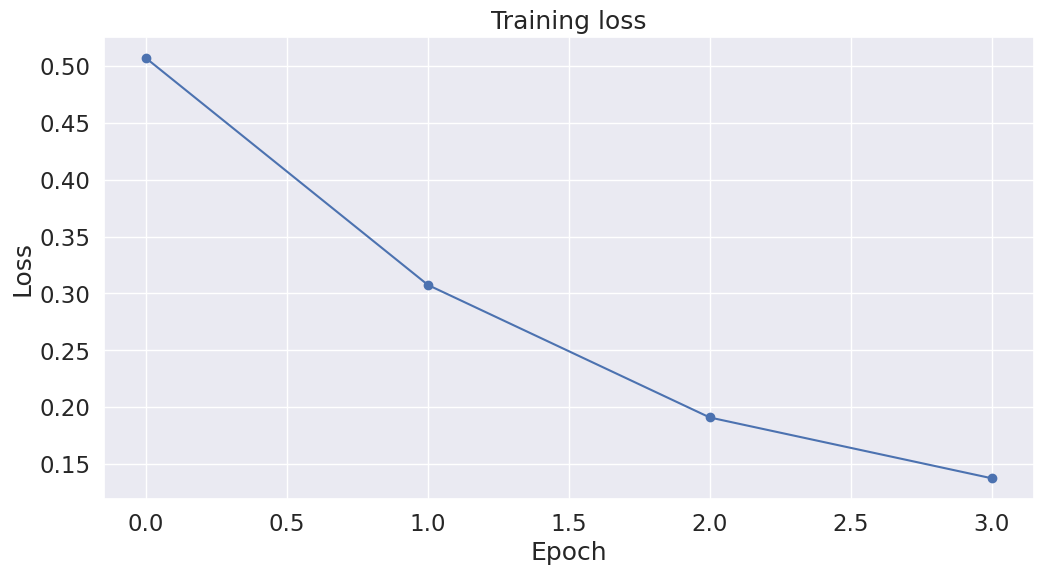

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 5. Performance On Test Set

test 용 데이터세트를 로드하고 [Matthew의 상관 계수](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)를 사용하여 예측을 평가합니다.

이 지표를 사용하면 +1이 최고 점수이고 -1이 최저 점수입니다. 이런 식으로 우리는 이 특정 작업에 대한 최신 모델에 비해 우리가 얼마나 잘 수행하는지 확인할 수 있습니다.

### 5.1. Data Preparation


In [26]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



## 5.2. Evaluate on Test Set


In [27]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [28]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [29]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [30]:
matthews_set

[-0.14856415213808927,
 -0.21684543705982773,
 0.4040950971038548,
 0.2757127976394358,
 0.0849411985729376,
 0.6777932975034471,
 0.5555555555555556,
 0.0,
 0.9165151389911681,
 0.8246211251235321,
 0.9229582069908973,
 0.647150228929434,
 0.8150678894028793,
 0.5204956780951701,
 0.1794871794871795,
 0.5056936741642399,
 0.0]

In [31]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.503
